In [178]:
import pickle
from multiprocessing import Pool
from glob import glob
from collections import Counter
from astropy.utils.data import get_pkg_data_filename
import pyink as pu

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from tqdm import tqdm as tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from reproject import reproject_interp

In [179]:
emu = glob('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
print(len(emu))
print(emu[0])

1
image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits


In [180]:
tab = Table.read('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits').to_pandas()
tab.head(5) # there are 35

,BEAM,NAME,RA,DEC,BMAJ,BMIN,BPA
0,0,b'./image.i.EMU_2115-6',-46.451871,-62.170819,12.190899,10.688850,88.638426
1,1,b'./image.i.EMU_2115-6',-44.525079,-62.230139,12.169599,10.691446,88.309974
2,2,b'./image.i.EMU_2115-6',-42.593279,-62.263139,12.506018,10.809036,-86.132462
3,3,b'./image.i.EMU_2115-6',-40.659321,-62.269739,12.109623,10.679411,87.676195
4,4,b'./image.i.EMU_2115-6',-38.726079,-62.249939,12.458843,10.789674,-86.844433


In [181]:
filename = get_pkg_data_filename('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
wcs.wcs.specsys = 'TOPOCENT'
#np.nanstd(np.squeeze(hdu.data)) #ignore all NaN 

Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [182]:
def radio_preprocessing(data, lower = 3):
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)

    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, 3*noise)):
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    return img_scale.astype(np.float32)

### RAW RADIO DATA

In [183]:
hdu.data

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)

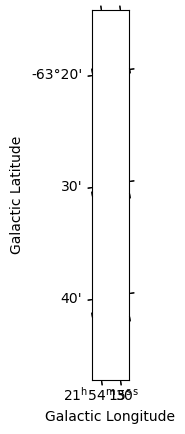

In [205]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 100, 0, 1000])
plt.imshow(np.squeeze(hdu.data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()
#hough circle only run on jpeg
#pybdsf runs on fits file

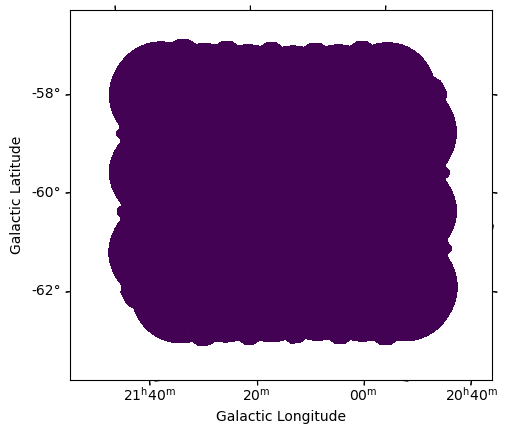

In [184]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597])
plt.imshow(np.squeeze(hdu.data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()
#hough circle only run on jpeg
#pybdsf runs on fits file

## WITH PREPROCESSED RADIO

In [30]:
#interested in `complex` objects
#preprocessed_radio = radio_preprocessing(hdu.data, lower = 3)

Export the preprocessed_radio into a separated file called `preprocessed_radio.txt` so that we dont have to run the preprocessing step again

In [185]:
import pickle
#file = open('preprocessed_radio.txt', 'wb')
#pickle.dump(preprocessed_radio, file)
#file.close()

file = open('preprocessed_radio.txt', 'rb')
preprocessed_data = pickle.load(file)
preprocessed_data #whenever the file is corrupted, just load this data into the preprocessed_radio data
preprocessed_radio = preprocessed_data


#embed the preprocessed data into the original glob
#preprocessed_hdu = hdu
#preprocessed_hdu.data = preprocessed_radio
#preprocessed_wcs = WCS(preprocessed_hdu.header)
#preprocessed_wcs.wcs.specsys = 'TOPOCENT'

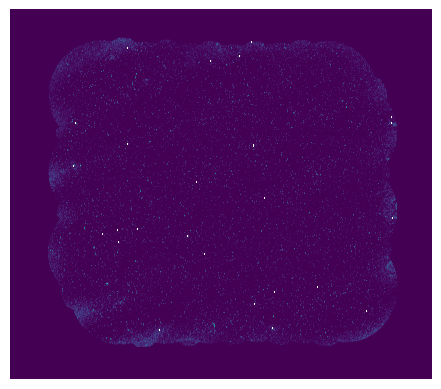

In [186]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597]) #0, 15515, 0, 13597
plt.imshow(np.squeeze(preprocessed_radio), origin='lower') #np.squeeze to lower the NAXIS to 2
plt.axis('off')
plt.savefig('preprocessed_EMU_image.png', dpi = 500, bbox_inches='tight')

#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()
#hough circle only run on jpeg
#pybdsf runs on fits file

We want to divide the image into 6 different segments for analysis. Hence we will divide the galaxy image into 6 different regions, 3 on the top and 3 on the bottom

Before dividing into regions, we need to trim empty spaces of the image through manual estimating:
- left: 1420 for x (trim it) right: 14234 for x (trim it)
- up : 12551 for y (trim it) bottom: 1185 for y (trim it)
- The limited x-range is now from 4654 to 9083, in which the length is 12814
- The limited y-range is now from 1185 to 12551, in which the length is 11366

using `np.linspace()` we estimate the regions as follows:
```
np.linspace(1420, 14234, 3 + 1)
np.linspace(1185, 12551, 2 + 1)
```

- The first image has the image length from 1420 to 5691 and width of 1185 to 6868
- The second image has the image length from 5692 to 9962 and width of 1185 to 6868
- The third image has the image length from 9963 to 14234 and width of 1185 to 6868
- The fouth image has the x-coordination from 1420 to 5691 and y-coordination from 6869 to 12551
- The fifth image has the x-coordination from 5692 to 9962 and y-coordination from 6869 to 12551
- The sixth image has the x-coordination from 9963 to 14234 and y-coordination from 6869 to 12551

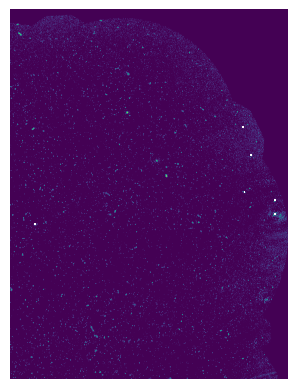

In [233]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_radio), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    plt.savefig(f'region{i+1}preprocessed_EMU_image.png', dpi = 500, bbox_inches='tight')

https://learn.astropy.org/tutorials/2-Coordinates-Transforms

---

## TEST ON GIVEN ORCS CIRCLE from this paper
https://academic.oup.com/mnras/article/513/1/1300/6553851?login=false

from this research site:
https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.1300N/graphics

https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html

In [39]:
from astropy.io import fits
 
with fits.open('orc1-askap.fits') as hdu_test:
    askap_orc_data = hdu_test[0].data
    askap_header = hdu_test[0].header
    askap_wcs = WCS(askap_header)

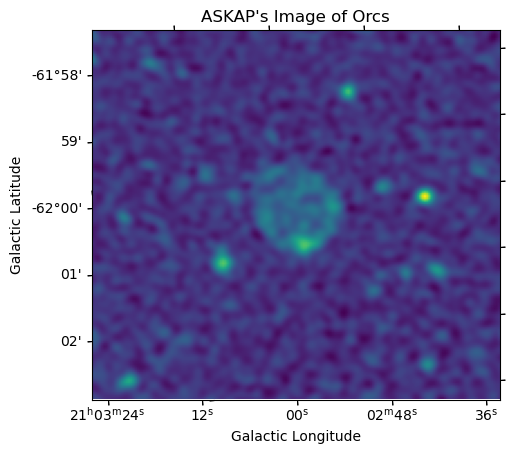

In [41]:
plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(askap_orc_data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#hough circle only run on jpeg
#pybdsf runs on fits file

In [16]:
def radio_preprocessing(data, lower = 3):
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)

    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, 3*noise)):
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    return img_scale.astype(np.float32)

In [17]:
#interested in `complex` objects
preprocessed_radio_ORCS = radio_preprocessing(askap_orc_data, lower = 3)

#save the current ORCS file
#hdu_test2 = hdu_test
#hdu_test2[0].data = preprocessed_radio_ORCS
#hdu_test2.writeto('preprocessed_radio_ORCS.fits')

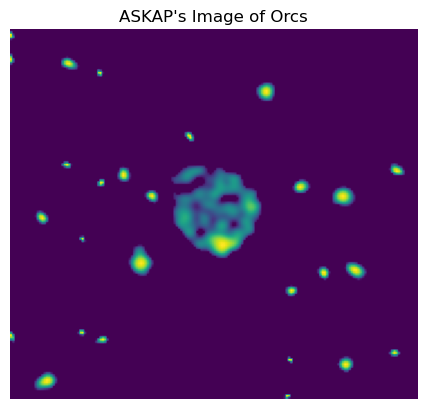

In [59]:
plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(preprocessed_radio_ORCS), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.axis('off')
plt.savefig('ASKAP_ORCS.jpg', dpi = 500, bbox_inches='tight')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
#hough circle only run on jpeg
#pybdsf runs on fits file

---

# Classification task

TEST ON ORCS SAMPLE IMAGE:

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [ ]:
img = cv.imread('ASKAP_ORCS.jpg')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, 600, 
                          param1=1000, param2=10, minRadius=100, maxRadius=200)
detected_circles = np.uint16(np.around(circles))
for (x, y, r) in detected_circles[0, :]:
    cv.circle(output, (x, y), r, (0, 255, 0), 10)
    cv.circle(output, (x, y), 2, (0, 255, 255), 20)
    
plt.imshow(output)
plt.show()

TEST ON ASTRONOMICAL IMAGE

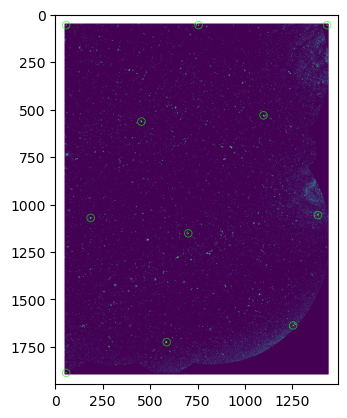

In [302]:
img = cv.imread('region3preprocessed_EMU_image.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=8, 
                          minRadius=5, 
                          maxRadius=10)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), 20, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), 1, (0, 255, 255), 2)  # Circle center

    # Display the image with detected circles
    plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
    plt.savefig('output_testing', dpi=500)
    plt.show()
else:
    print("No circles were detected. Try adjusting the parameters.")

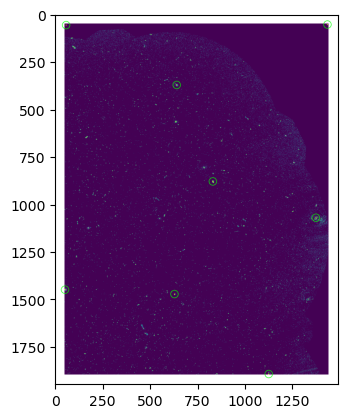

In [303]:
img = cv.imread('region6preprocessed_EMU_image.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=10, 
                          minRadius=5, 
                          maxRadius=10)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), 20, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), 1, (0, 255, 255), 2)  # Circle center

    # Display the image with detected circles
    plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
    plt.savefig('output_testing', dpi=500)
    plt.show()
else:
    print("No circles were detected. Try adjusting the parameters.")

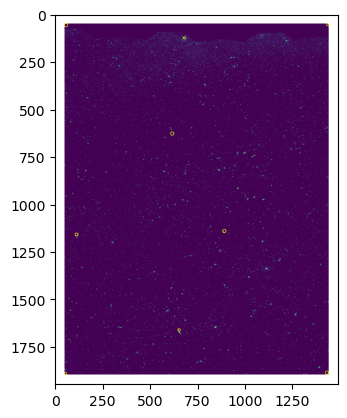

In [305]:
img = cv.imread('region5preprocessed_EMU_image.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=10, 
                          minRadius=5, 
                          maxRadius=10)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), r, (0, 255, 255), 2)  # Circle center

    # Display the image with detected circles
    plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
    plt.savefig('output_testing', dpi=500)
    plt.show()
else:
    print("No circles were detected. Try adjusting the parameters.")

---

REFERENCE:

https://academic.oup.com/mnras/article/513/1/1300/6553851?login=false